# Assignment 3: Improving the Pipeline
## DonorsChoose Dataset
### Kyle Schindl

## Part 1: Data Cleaning:

First, we commence with some minor data cleaning, as well as data visualization and summary statistics to better understand our dataset

In [1]:
import HW5_pipeline as up
import pandas as pd

#Read in dataset
data = pd.read_csv('projects_2012_2013.csv')

#Convert relevant columns to datetime
data['date_posted'] = pd.to_datetime(data.date_posted)
data['datefullyfunded'] = pd.to_datetime(data.datefullyfunded)

#Create target column based on chosen criteria
data['target'] = ((data['datefullyfunded'] - data['date_posted']).dt.days > 60) * 1

#Create categorical variables for data analysis
for col in ['school_metro', 'primary_focus_subject', 'primary_focus_area', 'secondary_focus_area',
            'secondary_focus_subject', 'secondary_focus_area', 'teacher_prefix', 'poverty_level',
            'resource_type', 'school_state', 'grade_level']:
    data[col] = data[col].astype('category')

#Convert string columns to dummy variables
up.convert_tf(data, ['school_magnet', 'school_charter', 'eligible_double_your_impact_match'], 'f')

#Drop superfluous columns
data = data.drop(['projectid', 'teacher_acctid', 'schoolid', 'school_ncesid',
                  'school_latitude', 'school_longitude', 'school_city', 'school_state',
                  'school_district', 'school_county', 'secondary_focus_area',
                  'secondary_focus_subject'], axis=1)

/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


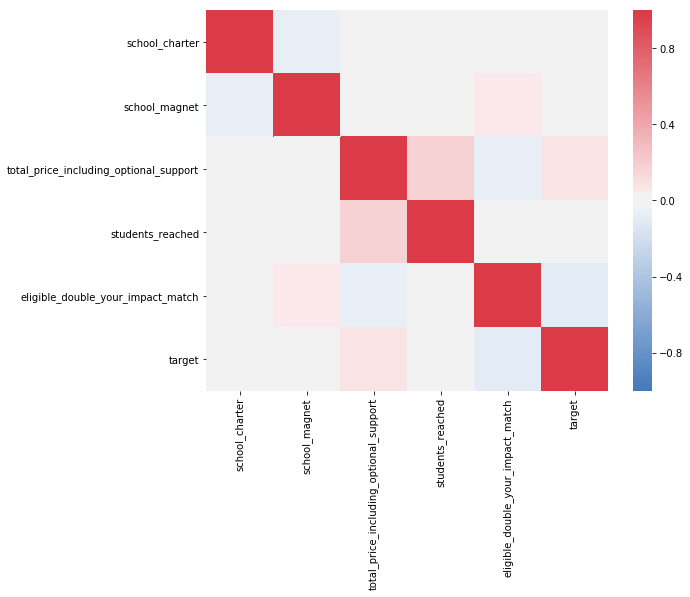

In [2]:
#We note that total price is positively correlated with our target variable
#and "eligible for double your impact match" is negatively correlated
up.create_heatmap(data, (9,7))

In [3]:
#Most of our missing data is in school_metro
up.get_nulls(data)

school_metro                              15224
school_charter                                0
school_magnet                                 0
teacher_prefix                                0
primary_focus_subject                        15
primary_focus_area                           15
resource_type                                17
poverty_level                                 0
grade_level                                   3
total_price_including_optional_support        0
students_reached                             59
eligible_double_your_impact_match             0
date_posted                                   0
datefullyfunded                               0
target                                        0
dtype: int64

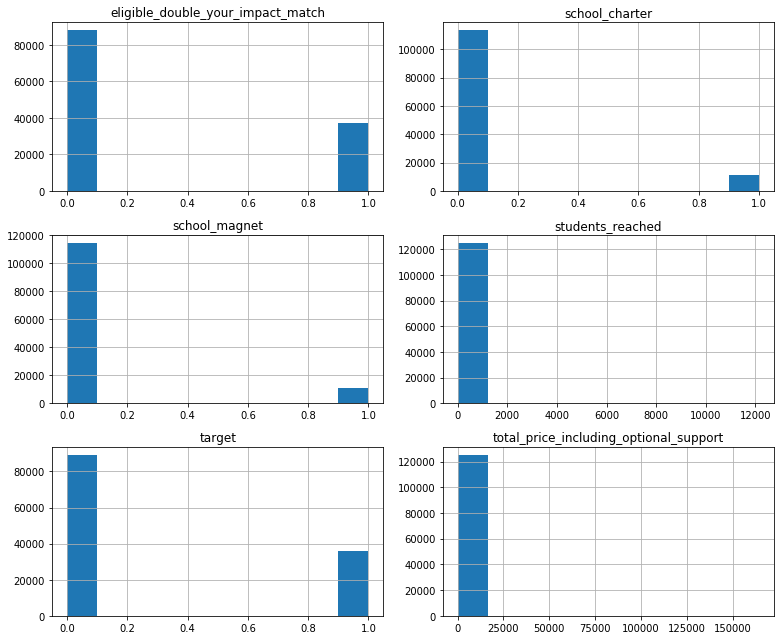

In [4]:
'''
We see that most schools are not charters or magnets. There also appear to
be some extreme outliers among students reached and total price
'''
up.get_histograms(data, (11,9))

In [5]:
'''
By checking the data summaries we confirm that there are extreme outliers
in the total price (with a max over $100,000) and students reached (with
a max over 10,000 students)
'''
up.get_summaries(data, list(data._get_numeric_data().columns))

,school_charter,school_magnet,total_price_including_optional_support,students_reached,eligible_double_your_impact_match,target
count,124976.000000,124976.000000,124976.000000,124917.000000,124976.000000,124976.000000
mean,0.093106,0.085640,654.011811,95.445760,0.296769,0.288135
std,0.290582,0.279833,1098.015854,163.481912,0.456836,0.452896
min,0.000000,0.000000,92.000000,1.000000,0.000000,0.000000
25%,0.000000,0.000000,345.810000,23.000000,0.000000,0.000000
50%,0.000000,0.000000,510.500000,30.000000,0.000000,0.000000
75%,0.000000,0.000000,752.960000,100.000000,1.000000,1.000000
max,1.000000,1.000000,164382.840000,12143.000000,1.000000,1.000000


## Part 2: Splitting and Imputing Data:

We must split our data before imputing in order to preserve the independence of training and testing sets. We choose a rolling window of six months for our test set, giving a total of three training/testing pairs.

Note that we leave a gap of 60 days between training/testing pairs in order to observe outcomes of training data.

In [6]:
'''
Calculates training test splits of:
    TRAINING: 2012/1/1 - 2012/4/30
    TESTING:  2012/7/1 - 2012/10/31
    
    TRAINING: 2012/1/1 - 2012/10/31
    TESTING:  2013/1/1 - 2013/4/30
    
    TRAINING: 2012/1/1 - 2013/4/30
    TESTING:  2013/7/1 - 2013/10/31
'''
splits = up.split_time(data, '2012-01-01', '2013-12-31', [6], 60)

train_test_splits = []
for split in splits:
    
    #Creates train/test pairs
    training, testing = up.create_data_splits(data, split, 'date_posted') 
    
    train_test_splits.append(training)
    train_test_splits.append(testing)

data_splits = []
for data_split in train_test_splits:  

    #Impute values for training, testing sets
    df = up.impute_values(data_split)
        
    #Convert categorical variables to dummies
    df = up.category_to_dummy(df)
    
    data_splits.append(df)
    
#Create list of features
feats = [col for col in data_splits[0].columns if col not in ['date_posted', 'datefullyfunded', 'target']]

#Creates tuples of training/testing pairs
train_test = iter(data_splits)
train_test_pairs = list(zip(train_test, train_test))

## Part 3: Model Building

Here, we establish the parameters and classifiers we will test,
then run the models

In [7]:
#Chosen parameters to run in classification model
parameters_large = { 
    'RF':{'n_estimators': [10,100,1000,10000], 'max_depth': [1,5,10,20,50,100], 'max_features': ['sqrt','log2'],'min_samples_split': [2,5,10], 'n_jobs': [-1]},
    'LR': { 'penalty': ['l1','l2'], 'C': [0.00001,0.0001,0.001,0.01,0.1,1,10]},
    'AB': { 'algorithm': ['SAMME', 'SAMME.R'], 'n_estimators': [1,10,100,1000,10000]},
    'GB': {'n_estimators': [1,10,100,1000,10000], 'learning_rate' : [0.001,0.01,0.05,0.1,0.5],'subsample' : [0.1,0.5,1.0], 'max_depth': [1,3,5,10,20,50,100]},
    'DT': {'criterion': ['gini', 'entropy'], 'max_depth': [1,5,10,20,50,100],'min_samples_split': [2,5,10]},
    'SVM' :{'C' :[0.00001,0.0001,0.001,0.01,0.1,1,10],'kernel':['linear']},
    'KNN' :{'n_neighbors': [1,5,10,25,50,100],'weights': ['uniform','distance'],'algorithm': ['auto','ball_tree','kd_tree']},
    'BG': {'n_estimators': [1,10,100], 'max_samples': [2, 4, 8, 16, 32]}}

parameters = {
    'RF': {'n_estimators': [10, 100, 1000], 'max_depth': [1, 5, 10], 'min_samples_split': [2, 5, 10], 'n_jobs': [-1]},
    'LR': {'penalty': ['l2'], 'C': [0.01, 0.1, 1, 10], 'solver': ['lbfgs']},
    'DT': {'criterion': ['gini', 'entropy'], 'max_depth': [1, 5, 10], 'min_samples_split': [2, 5, 50]},
    'KNN': {'n_neighbors': [5, 10, 25, 50], 'weights': ['uniform', 'distance']},
    'AB': {'algorithm': ['SAMME.R'], 'n_estimators': [1, 10, 100, 1000]},
    'GB': {'n_estimators': [10, 100], 'max_depth': [3, 5, 10]},
    'BG': {'n_estimators': [10, 100], 'random_state': [0], 'n_jobs': [-1]}}

#Chosen thresholds
thresholds = [1.0, 2.0, 5.0, 10.0, 20.0, 30.0, 50.0]

#Models we have chosen to run for DonorsChoose
models_to_run = ['RF', 'LR', 'AB', 'GB', 'DT', 'KNN', 'BG']

#Initialization of chosen classifiers
classifiers = {'RF': up.RandomForestClassifier(n_estimators=50, n_jobs=-1),
               'AB': up.AdaBoostClassifier(up.DecisionTreeClassifier(max_depth=1),
                     algorithm="SAMME", n_estimators=200),
               'LR': up.LogisticRegression(penalty='l1', C=1e5),
               'SVM': up.svm.SVC(kernel='linear', probability=True, random_state=0),
               'GB': up.GradientBoostingClassifier(learning_rate=0.05, subsample=0.5,
                     max_depth=6, n_estimators=10),
               'DT': up.DecisionTreeClassifier(),
               'KNN': up.KNeighborsClassifier(n_neighbors=3),
               'BG': up.BaggingClassifier()}

results = up.classify(train_test_pairs, classifiers, feats, 'target', parameters, models_to_run, thresholds)

## Part 4: Evaluation

In [41]:
#By sorting by precision, then auc-roc we choose a DT classifier as the 'best' model
results[results['threshold'] == 5.0].sort_values(by=['precision', 'auc-roc'], ascending=False)[:5]

,model_type,time_period,classifier,parameters,threshold,auc-roc,precision,recall,f1_score
1276,DT,3,"DecisionTreeClassifier(class_weight=None, crit...","{'min_samples_split': 2, 'criterion': 'gini', ...",5.0,0.647045,1.0,0.187255,0.315442
1283,DT,3,"DecisionTreeClassifier(class_weight=None, crit...","{'min_samples_split': 5, 'criterion': 'gini', ...",5.0,0.647045,1.0,0.187255,0.315442
1290,DT,3,"DecisionTreeClassifier(class_weight=None, crit...","{'min_samples_split': 50, 'criterion': 'gini',...",5.0,0.647045,1.0,0.187255,0.315442
1339,DT,3,"DecisionTreeClassifier(class_weight=None, crit...","{'min_samples_split': 2, 'criterion': 'entropy...",5.0,0.643889,1.0,0.187255,0.315442
1346,DT,3,"DecisionTreeClassifier(class_weight=None, crit...","{'min_samples_split': 5, 'criterion': 'entropy...",5.0,0.643889,1.0,0.187255,0.315442


In [82]:
#Setting parameters for 'best' DT to plot precision/recall
params = results.iloc[1276]['parameters']
best = results.iloc[1276]['classifier']
best.set_params(**params)

#Finding the train test split in period 3
train, test = train_test_pairs[-1]

X_train_best = train[feats]
y_train_best = train['target']


X_test_best = test[feats]
y_test_best = test['target']

y_pred = best.fit(X_train_best, y_train_best).predict_proba(X_test_best)[:, 1]

<Figure size 432x288 with 0 Axes>

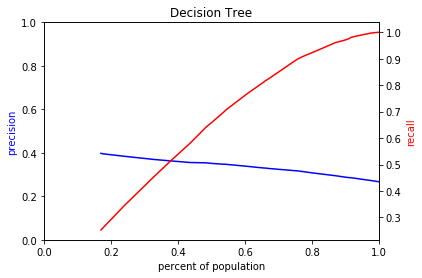

In [83]:
up.plot_precision_recall_n(y_test_best, y_pred, "Decision Tree")

In [84]:
#Evaluation metrics sorted by time period, threshold, and model type
results.groupby(['time_period', 'threshold','model_type']).median()

auc-roc  precision    recall  f1_score
time_period threshold model_type                                         
1           1.0       AB          0.649828   0.532328  0.021300  0.040962
                      BG          0.609457   0.476293  0.019058  0.036650
                      DT          0.624039   0.980603  0.039238  0.075456
                      GB          0.643206   0.491379  0.019662  0.037811
                      KNN         0.597634   0.387931  0.015523  0.029851
                      LR          0.624344   0.469828  0.018800  0.036153
                      RF          0.650169   0.461207  0.018455  0.035489
            2.0       AB          0.649828   0.538710  0.043205  0.079994
                      BG          0.609457   0.448387  0.035961  0.066582
                      DT          0.624039   0.990323  0.079424  0.147054
                      GB          0.643206   0.448387  0.035961  0.066582
                      KNN         0.597634   0.397849  0.031908  0.059077
                      LR          0.624344   0.426882  0.034236  0.063388
                      RF          0.650169   0.425806  0.034150  0.063228
            5.0       AB          0.649828   0.449313  0.090204  0.150244
                      BG          0.609457   0.411942  0.082701  0.137748
                      DT          0.624039   0.514605  0.103311  0.172077
                      GB          0.643206   0.409364  0.082184  0.136886
                      KNN         0.597634   0.369416  0.074164  0.123528
                      LR          0.624344   0.421392  0.084598  0.140908
                      RF          0.650169   0.402921  0.080890  0.134731
            10.0      AB          0.649828   0.406827  0.163418  0.233173
                      BG          0.609457   0.367754  0.147723  0.210779
                      DT          0.624039   0.584371  0.234736  0.334933
                      GB          0.643206   0.391155  0.157123  0.224191
                      KNN         0.597634   0.356161  0.143067  0.204134
                      LR          0.624344   0.393517  0.158072  0.225544
                      RF          0.650169   0.381709  0.153329  0.218777
            20.0      AB          0.649828   0.372585  0.299327  0.331963
                      BG          0.609457   0.370867  0.297948  0.330432
...                                    ...        ...       ...       ...
3           5.0       LR          0.624395   0.416667  0.078023  0.131434
                      RF          0.656575   0.451204  0.084490  0.142329
            10.0      AB          0.655466   0.462452  0.173193  0.252007
                      BG          0.618044   0.445342  0.166785  0.242683
                      DT          0.640492   0.701838  0.262846  0.382457
                      GB          0.657157   0.432510  0.161979  0.235690
                      KNN         0.602631   0.375000  0.140441  0.204351
                      LR          0.624395   0.406210  0.152130  0.221359
                      RF          0.656575   0.427757  0.160199  0.233100
            20.0      AB          0.655466   0.414528  0.310490  0.355044
                      BG          0.618044   0.428311  0.320814  0.366850
                      DT          0.640492   0.437579  0.327756  0.374788
                      GB          0.657157   0.405101  0.303429  0.346971
                      KNN         0.602631   0.356702  0.267177  0.305516
                      LR          0.624395   0.384664  0.288122  0.329466
                      RF          0.656575   0.402883  0.301768  0.345071
            30.0      AB          0.655466   0.388308  0.436276  0.410897
                      BG          0.618044   0.394592  0.443337  0.417547
                      DT          0.640492   0.393747  0.442388  0.416653
                      GB          0.657157   0.387621  0.435505  0.410170
                      KNN         0.602631   0.349810  0.393022  0.370159
                      LR          0.624